In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if '..' not in sys.path:
    sys.path.append('..')

from data import ThreeBallsCollisionFullSceneDataset

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.functional import mse_loss as mse_pytorch

import reservoirpy as rpy
from reservoirpy.observables import mse as mse_esn

from itertools import product
from tqdm.notebook import tqdm_notebook

from models import VanilaRNN, GRU, LSTM, ESN, SeqESN, ParallelESN, GroupedESN

rpy.verbosity(0)

import pickle

# Importing data

In [2]:
batch_size = 32

train_data, test_data = ThreeBallsCollisionFullSceneDataset.train_test_split('../data/raw/three-balls-collisions-full-scene-limited-free-fall-tuning', test_frac=0.2, max_actions=200, free_fall_fraction=0.15)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  3637
train_test_split response: test fraction rounded to 0.19995601737313762 (3637 simulations)


In [3]:
batch_size = 32

train_data_full, test_data_full = ThreeBallsCollisionFullSceneDataset.train_test_split('../data/raw/three-balls-collisions-full-scene-limited-free-fall', test_frac=0.2, max_actions=3000, free_fall_fraction=0.15)

train_dataloader_full = DataLoader(dataset=train_data_full, batch_size=batch_size)
test_dataloader_full = DataLoader(dataset=test_data_full, batch_size=batch_size)

Test size:  54811
train_test_split response: test fraction rounded to 0.1999985404496145 (54811 simulations)


# Traditional RNNs

## Hyperparameter tuning

In [5]:
# dictionary to store the results
results = {}

results_file = 'results_dict_full_scene.pkl'

try:
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
except:
    results = {}

In [13]:
hidden_dims = [64, 96, 128, 192, 258]
nums_rnns = [1, 2, 3]
dropout_probs = [0, 0.1]

if 'vanilla_rnn' not in results.keys():

    # Performing cross-validation hypterparameter turning

    results['vanilla_rnn'] = []

for hidden_dim, num_rnns, dropout_prob in tqdm_notebook(product(hidden_dims, nums_rnns, dropout_probs)):
    set_included = False
    for val_set in results['vanilla_rnn']:
        if val_set['hidden_dim'] == hidden_dim and val_set['num_rnns'] == num_rnns and val_set['dropout_prob'] == dropout_prob:
            print(f'Value set already included: hidden_dim={hidden_dim}\t num_rnns={num_rnns}\t dropout_prob={dropout_prob}')
            set_included = True
            break

    if set_included:
        continue

    if num_rnns == 1 and dropout_prob != 0:
        continue

    print(f'Testing hidden_dim={hidden_dim}\t num_rnns={num_rnns}\t dropout_prob={dropout_prob}')

    vanila_rnn = VanilaRNN.train_model(train_dataloader=train_dataloader, error_threshold=10000, input_dim=9, hidden_dim=hidden_dim, num_rnns=num_rnns, output_dim=144, dropout_prob=dropout_prob)
    test_loss = VanilaRNN.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=False)

    results['vanilla_rnn'].append(
        {
            'hidden_dim': hidden_dim,
            'num_rnns': num_rnns,
            'dropout_prob': dropout_prob,
            'test_loss': test_loss
        }
    )

    print()

    with open(results_file, 'wb') as f:
        pickle.dump(results, f)

0it [00:00, ?it/s]

Value set already included: hidden_dim=64	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=64	 num_rnns=3	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=3	 dropout_prob=0.1
Value set already included: hidden_dim=96	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=96	 num_rnns=3	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=3	 dropout_prob=0.1
Value set already included: hidden_dim=128	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=128	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=128	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=128	 num_rnns=3	 dropout_prob=0
Value 

In [14]:
if 'gru' not in results.keys():

    # Performing cross-validation hypterparameter turning

    results['gru'] = []

for hidden_dim, num_rnns, dropout_prob in tqdm_notebook(product(hidden_dims, nums_rnns, dropout_probs)):
    set_included = False
    for val_set in results['gru']:
        if val_set['hidden_dim'] == hidden_dim and val_set['num_rnns'] == num_rnns and val_set['dropout_prob'] == dropout_prob:
            print(f'Value set already included: hidden_dim={hidden_dim}\t num_rnns={num_rnns}\t dropout_prob={dropout_prob}')
            set_included = True
            break

    if set_included:
        continue

    if num_rnns == 1 and dropout_prob != 0:
        continue

    print(f'Testing hidden_dim={hidden_dim}\t num_rnns={num_rnns}\t dropout_prob={dropout_prob}')

    vanila_rnn = VanilaRNN.train_model(train_dataloader=train_dataloader, error_threshold=10000, input_dim=9, hidden_dim=hidden_dim, num_rnns=num_rnns, output_dim=144, dropout_prob=dropout_prob)
    test_loss = VanilaRNN.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=False)

    results['gru'].append(
        {
            'hidden_dim': hidden_dim,
            'num_rnns': num_rnns,
            'dropout_prob': dropout_prob,
            'test_loss': test_loss
        }
    )

    print()

    with open(results_file, 'wb') as f:
        pickle.dump(results, f)

0it [00:00, ?it/s]

Value set already included: hidden_dim=64	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=64	 num_rnns=3	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=3	 dropout_prob=0.1
Value set already included: hidden_dim=96	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=96	 num_rnns=3	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=3	 dropout_prob=0.1
Value set already included: hidden_dim=128	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=128	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=128	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=128	 num_rnns=3	 dropout_prob=0
Value 

In [15]:
if 'lstm' not in results.keys():

    # Performing cross-validation hypterparameter turning

    results['lstm'] = []

for hidden_dim, num_rnns, dropout_prob in tqdm_notebook(product(hidden_dims, nums_rnns, dropout_probs)):
    set_included = False
    for val_set in results['lstm']:
        if val_set['hidden_dim'] == hidden_dim and val_set['num_rnns'] == num_rnns and val_set['dropout_prob'] == dropout_prob:
            print(f'Value set already included: hidden_dim={hidden_dim}\t num_rnns={num_rnns}\t dropout_prob={dropout_prob}')
            set_included = True
            break

    if set_included:
        continue

    if num_rnns == 1 and dropout_prob != 0:
        continue

    print(f'Testing hidden_dim={hidden_dim}\t num_rnns={num_rnns}\t dropout_prob={dropout_prob}')

    vanila_rnn = VanilaRNN.train_model(train_dataloader=train_dataloader, error_threshold=10000, input_dim=9, hidden_dim=hidden_dim, num_rnns=num_rnns, output_dim=144, dropout_prob=dropout_prob)
    test_loss = VanilaRNN.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader, test_data, visualize_first_10_trajectories=False)

    results['lstm'].append(
        {
            'hidden_dim': hidden_dim,
            'num_rnns': num_rnns,
            'dropout_prob': dropout_prob,
            'test_loss': test_loss
        }
    )

    print()

    with open(results_file, 'wb') as f:
        pickle.dump(results, f)

0it [00:00, ?it/s]

Value set already included: hidden_dim=64	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=64	 num_rnns=3	 dropout_prob=0
Value set already included: hidden_dim=64	 num_rnns=3	 dropout_prob=0.1
Value set already included: hidden_dim=96	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=96	 num_rnns=3	 dropout_prob=0
Value set already included: hidden_dim=96	 num_rnns=3	 dropout_prob=0.1
Value set already included: hidden_dim=128	 num_rnns=1	 dropout_prob=0
Value set already included: hidden_dim=128	 num_rnns=2	 dropout_prob=0
Value set already included: hidden_dim=128	 num_rnns=2	 dropout_prob=0.1
Value set already included: hidden_dim=128	 num_rnns=3	 dropout_prob=0
Value 

## Vanilla RNN

In [16]:
best_result_vanilla = min(results['vanilla_rnn'], key=lambda x: x['test_loss'])
best_result_vanilla

{'hidden_dim': 128,
 'num_rnns': 3,
 'dropout_prob': 0,
 'test_loss': tensor(0.0486, requires_grad=True)}

Calculated loss:  tensor(0.0495, grad_fn=<PowBackward0>)


Plotting progress: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


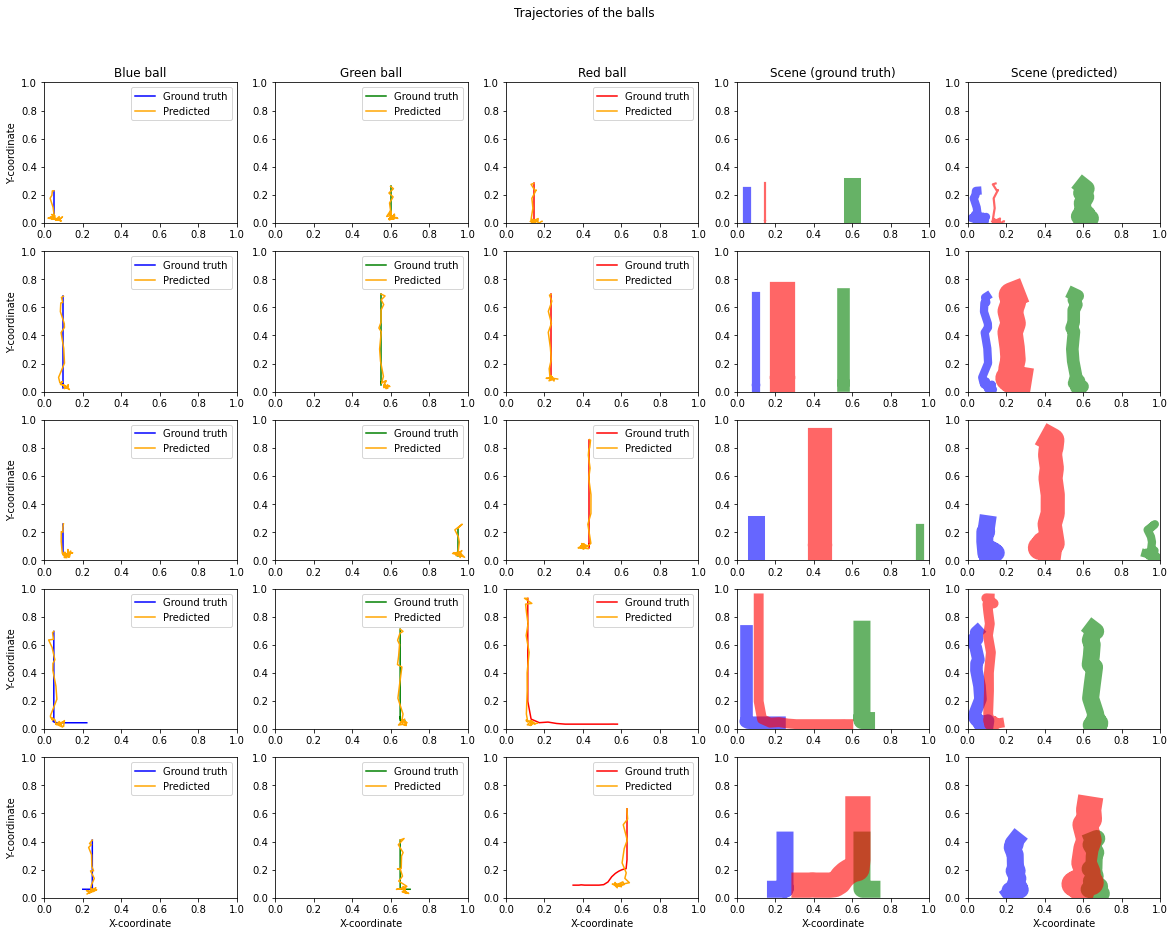

tensor(0.0495, grad_fn=<PowBackward0>)

In [17]:
file_name_vanilla = '../models/trained_models/full_scene/vanilla_rnn_full_scene.pt'
vanila_rnn = None

try:
    vanila_rnn = torch.load(file_name_vanilla)
except FileNotFoundError:
    vanila_rnn = VanilaRNN.train_model(num_epochs=100, train_dataloader=train_dataloader_full, error_threshold=1000, input_dim=9, hidden_dim=best_result_vanilla['hidden_dim'], num_rnns=best_result_vanilla['num_rnns'], output_dim=144, dropout_prob=best_result_vanilla['dropout_prob'])
    torch.save(vanila_rnn, file_name_vanilla)

VanilaRNN.calculate_loss(vanila_rnn, mse_pytorch, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)

## GRU

In [18]:
best_result_gru = min(results['gru'], key=lambda x: x['test_loss'])
best_result_gru

{'hidden_dim': 128,
 'num_rnns': 2,
 'dropout_prob': 0,
 'test_loss': tensor(0.0485, requires_grad=True)}

Calculated loss:  tensor(0.0468, grad_fn=<PowBackward0>)


Plotting progress: 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


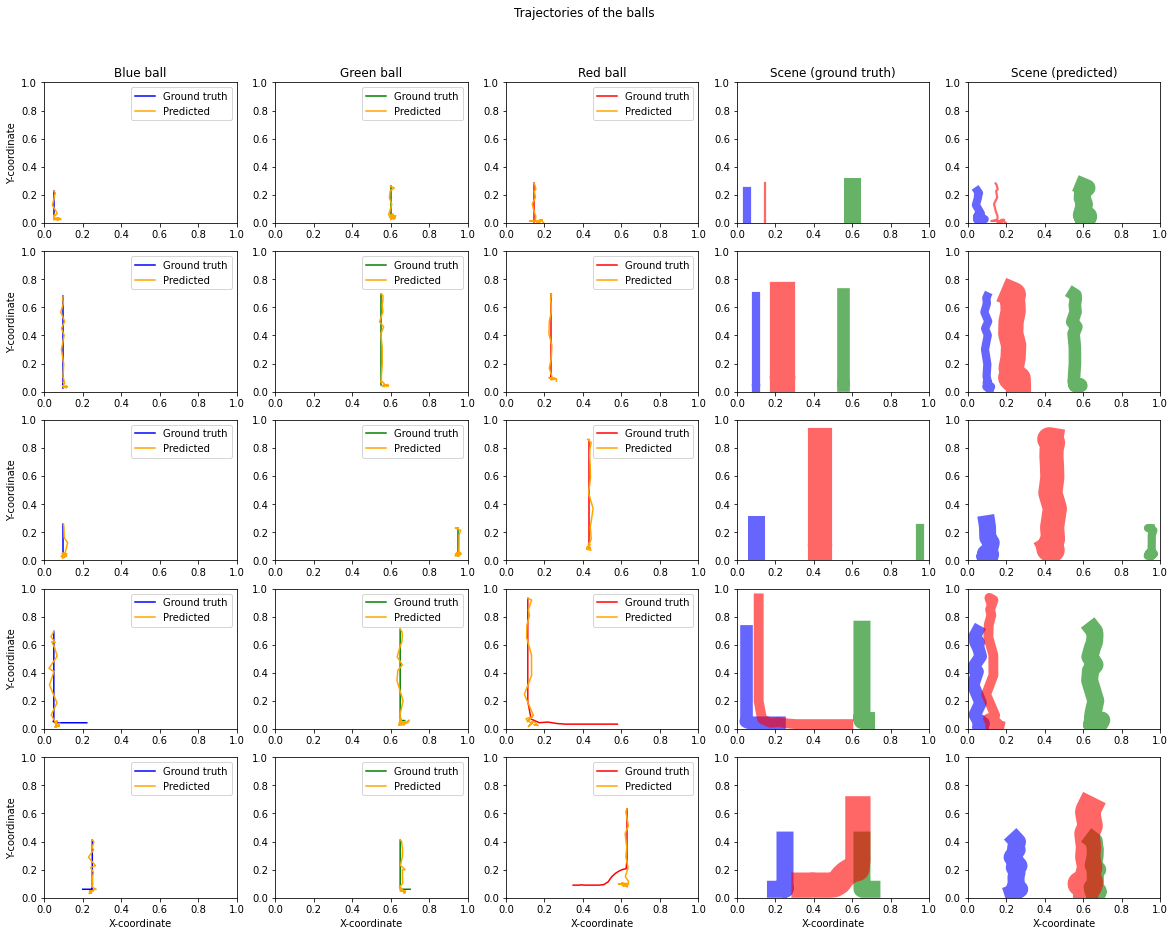

tensor(0.0468, grad_fn=<PowBackward0>)

In [19]:
file_name_gru = '../models/trained_models/full_scene/gru_full_scene.pt'
gru = None

try:
    gru = torch.load(file_name_gru)
except FileNotFoundError:
    gru = GRU.train_model(num_epochs=100, train_dataloader=train_dataloader_full, error_threshold=1000, input_dim=9, hidden_dim=best_result_gru['hidden_dim'], num_rnns=best_result_gru['num_rnns'], output_dim=144, dropout_prob=best_result_gru['dropout_prob'])
    torch.save(gru, file_name_gru)

GRU.calculate_loss(gru, mse_pytorch, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)

## LSTM

In [20]:
best_result_lstm = min(results['lstm'], key=lambda x: x['test_loss'])
best_result_lstm

{'hidden_dim': 128,
 'num_rnns': 2,
 'dropout_prob': 0,
 'test_loss': tensor(0.0485, requires_grad=True)}

Calculated loss:  tensor(0.0463, grad_fn=<PowBackward0>)


Plotting progress: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


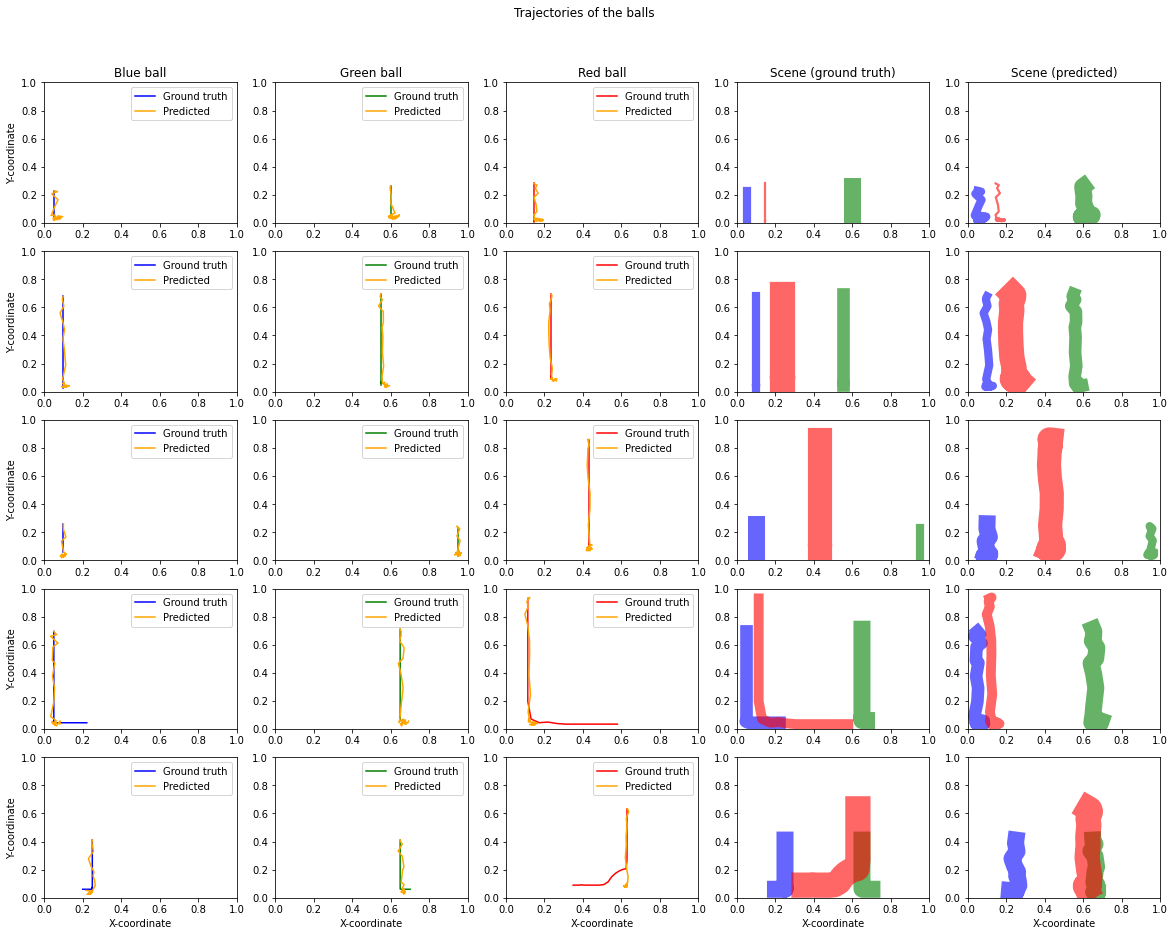

tensor(0.0463, grad_fn=<PowBackward0>)

In [21]:
file_name_lstm = '../models/trained_models/full_scene/lstm_full_scene.pt'
lstm = None

try:
    lstm = torch.load(file_name_lstm)
except FileNotFoundError:
    lstm = LSTM.train_model(num_epochs=100, train_dataloader=train_dataloader_full, error_threshold=1000, input_dim=9, hidden_dim=best_result_lstm['hidden_dim'], num_rnns=best_result_lstm['num_rnns'], output_dim=144, dropout_prob=best_result_lstm['dropout_prob'])
    torch.save(lstm, file_name_lstm)

LSTM.calculate_loss(lstm, mse_pytorch, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)

# RC Models

## Hyperparameter tuning

In [ ]:
n_units = [200, 250, 300, 350]
lrs = [0.7, 0.9]
srs = [0.1, 0.3]
ridges = [0.01, 0.1]

if 'esn' not in results.keys():

    # Performing cross-validation hypterparameter turning

    results['esn'] = []

for units, lr, sr, ridge in tqdm_notebook(product(n_units, lrs, srs, ridges)):
    set_included = False
    for val_set in results['esn']:
        if val_set['units'] == units and val_set['lr'] == lr and val_set['sr'] == sr and val_set['ridge'] == ridge:
            print(f'Value set already included: units={units} \t lr={lr} \t sr={sr} \t ridge={ridge}')
            set_included = True
            break

    if set_included:
        continue

    print(f'Testing units={units} \t lr={lr} \t sr={sr} \t ridge={ridge}')

    rpy.set_seed(42)

    esn = ESN.train_model(train_dataloader=train_dataloader, input_dim=9, reservoir_size=units, output_dim=144, leaking_rate=lr, spectral_radius=sr, ridge_param=ridge)
    test_loss = ESN.calculate_loss(esn, mse_esn, test_dataloader, test_data, visualize_first_10_trajectories=False)

    results['esn'].append(
        {
            'units': units,
            'lr': lr,
            'sr': sr,
            'ridge': ridge,
            'test_loss': test_loss
        }
    )

    print()

    with open(results_file, 'wb') as f:
        pickle.dump(results, f)

In [7]:
best_result_esn = min(results['esn'], key=lambda x: x['test_loss'])
best_result_esn

{'units': 300,
 'lr': 0.9,
 'sr': 0.3,
 'ridge': 0.1,
 'test_loss': 0.17577105173930868}

## Simple ESN

'Model-7': Model('Reservoir-6', 'Ridge-4')
Test loss:  0.18665799851457282


Plotting progress: 100%|██████████| 5/5 [00:12<00:00,  2.53s/it]


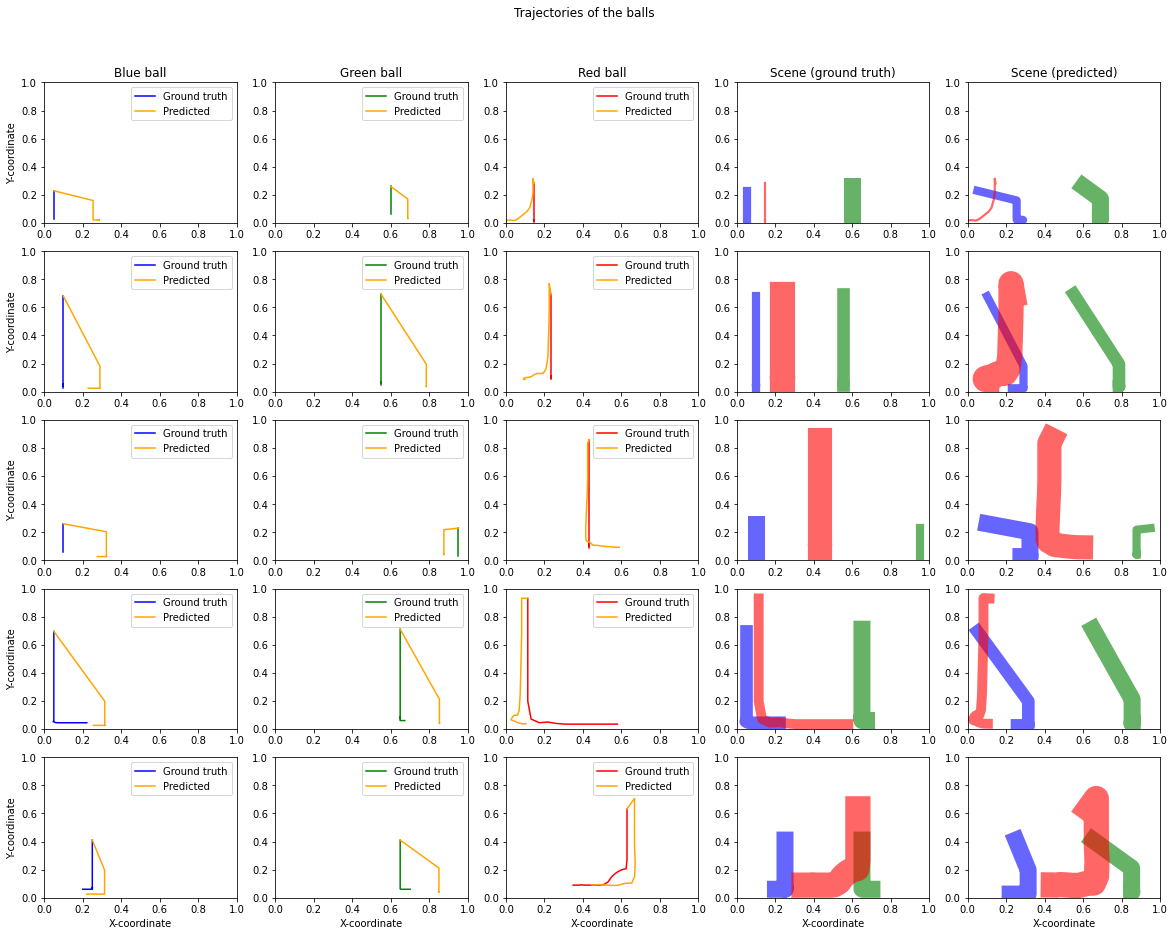

0.18665799851457282

In [12]:
rpy.set_seed(42)
esn = ESN.train_model(train_dataloader=train_dataloader_full, input_dim=9, reservoir_size=best_result_esn['units'], output_dim=144, leaking_rate=best_result_esn['lr'], spectral_radius=best_result_esn['sr'], ridge_param=best_result_esn['ridge'])

ESN.calculate_loss(esn, mse_esn, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)

## SeqESN

'Model-6': Model('Input-0', 'Reservoir-4', 'Ridge-2', 'Reservoir-5', 'Ridge-3')
Test loss:  0.21596867720312196


Plotting progress: 100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


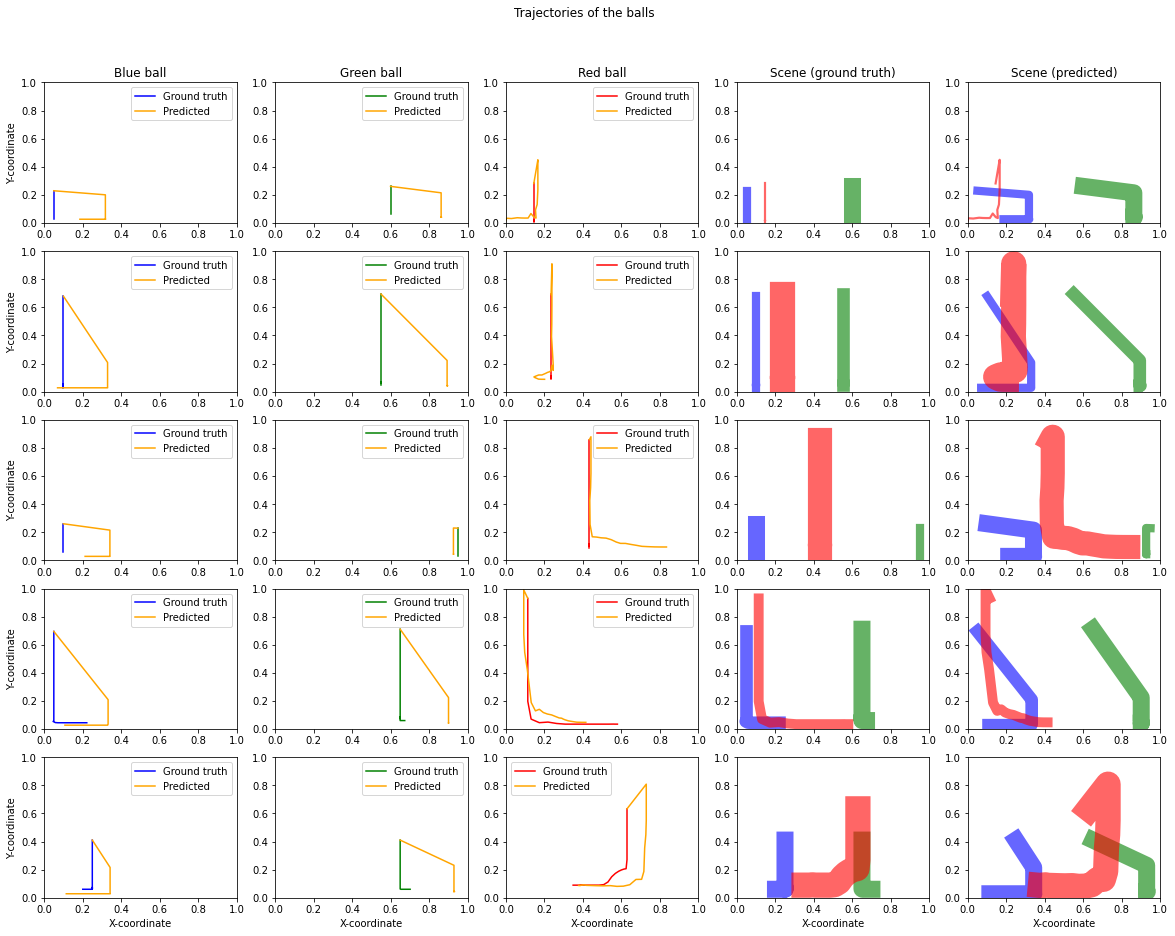

0.21596867720312196

In [10]:
rpy.set_seed(42)

seq_esn = SeqESN.train_model(train_dataloader=train_dataloader_full, input_dim=9, reservoir_size=best_result_esn['units'], output_dim=144, leaking_rate=best_result_esn['lr'], spectral_radius=best_result_esn['sr'], ridge_param=best_result_esn['ridge'], number_of_reservoirs=2)
SeqESN.calculate_loss(seq_esn, mse_esn, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)

## Parallel ESN

'Model-1': Model('Reservoir-0', 'Reservoir-1', 'Concat-0', 'Ridge-0')
Test loss:  0.21760136229659963


Plotting progress: 100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


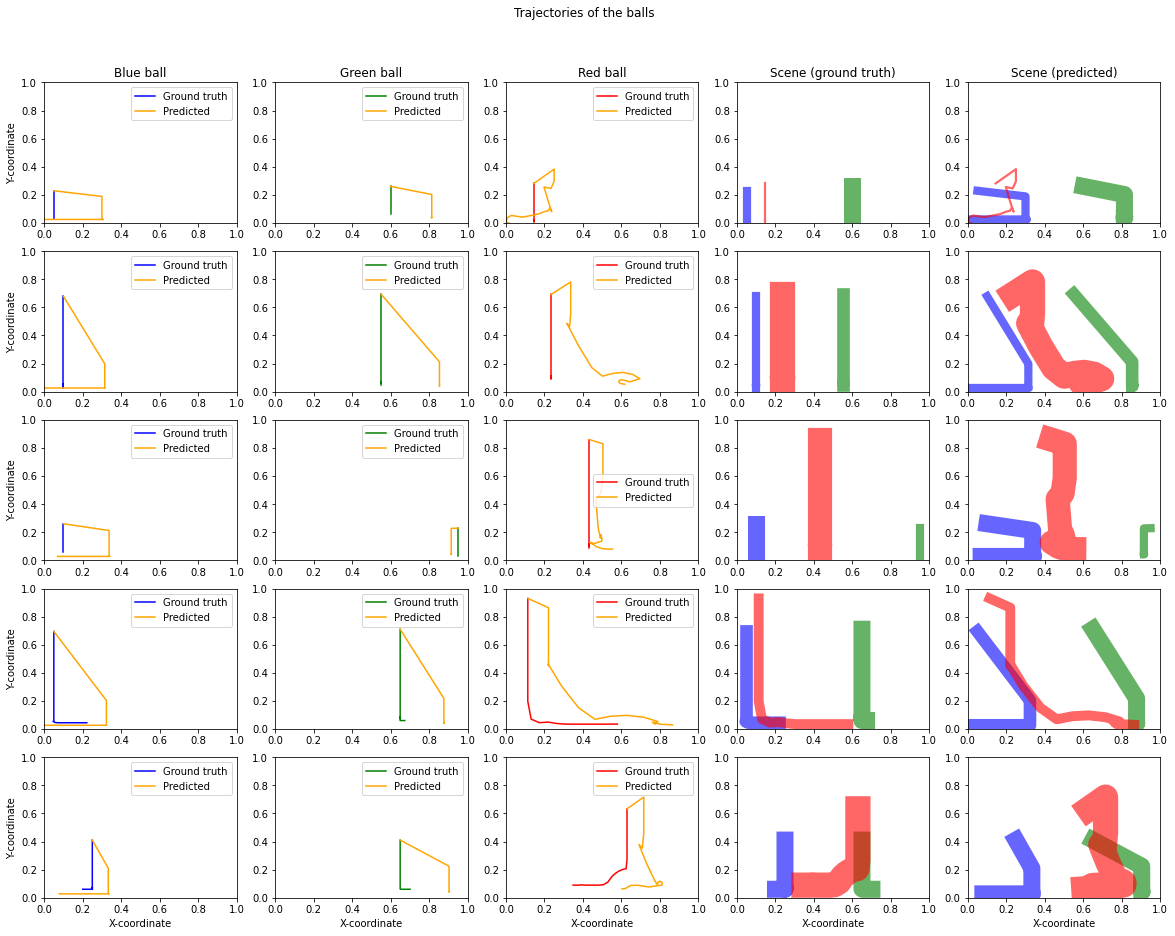

0.21760136229659963

In [8]:
rpy.set_seed(42)

parallel_esn = ParallelESN.train_model(train_dataloader=train_dataloader_full, input_dim=9, reservoir_size=best_result_esn['units'], output_dim=144, leaking_rate=best_result_esn['lr'], spectral_radius=best_result_esn['sr'], ridge_param=best_result_esn['ridge'], number_of_reservoirs=2)
ParallelESN.calculate_loss(parallel_esn, mse_esn, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)

## Grouped ESN

'Model-2': Model('Reservoir-3', 'Reservoir-2', 'Concat-1', 'Ridge-1')
Test loss:  0.18984812727038186


Plotting progress: 100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


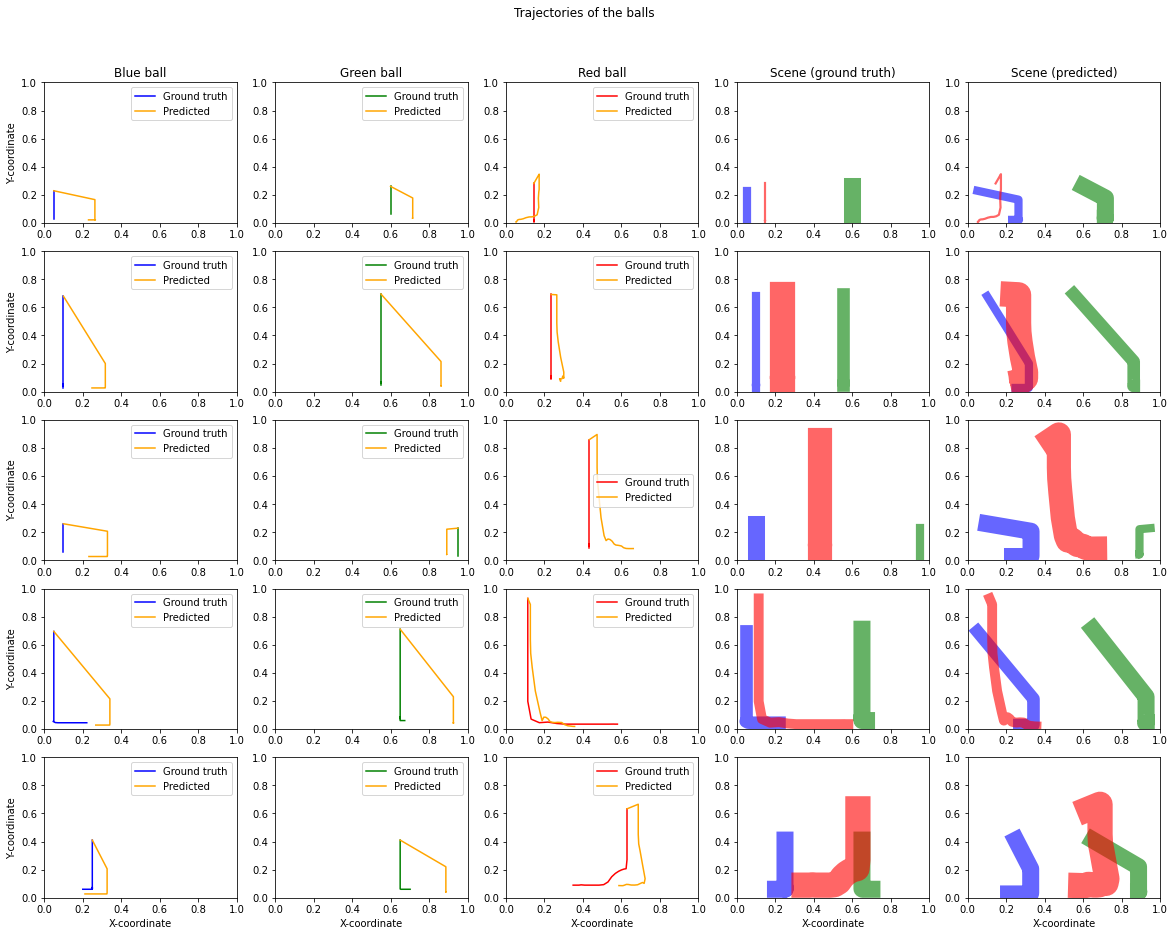

0.18984812727038186

In [9]:
rpy.set_seed(42)

grouped_esn = GroupedESN.train_model(train_dataloader=train_dataloader_full, input_dim=9, reservoir_size=best_result_esn['units'], output_dim=144, leaking_rate=best_result_esn['lr'], spectral_radius=best_result_esn['sr'], ridge_param=best_result_esn['ridge'], number_of_reservoirs=2)
GroupedESN.calculate_loss(grouped_esn, mse_esn, test_dataloader_full, test_data_full, visualize_first_10_trajectories=True)